In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import pickle

In [2]:
# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Preprocess data
def preprocess_data(images, labels):
    images_rgb = np.stack([images] * 3, axis=-1)
    images_resized = tf.image.resize(images_rgb, [32, 32]).numpy()
    images_normalized = images_resized / 255.0
    labels_categorical = to_categorical(labels, 10)
    return images_normalized, labels_categorical
x_train_processed, y_train_processed = preprocess_data(x_train, y_train)
x_test_processed, y_test_processed = preprocess_data(x_test, y_test)

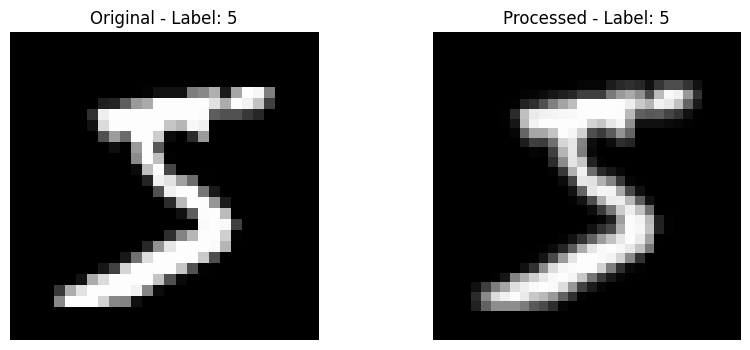

In [5]:
# Visualize sample data
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], cmap='gray')
plt.title(f'Original - Label: {y_train[0]}')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train_processed[0])
plt.title(f'Processed - Label: {y_train[0]}')
plt.axis('off')
plt.show()

In [6]:
# Create transfer learning model
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False

    inputs = Input(shape=(32, 32, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model, base_model
model, base_model = create_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/tmp/ipython-input-614930415.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,430,858 (9.27 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Callbacks
os.makedirs('saved_models', exist_ok=True)
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    ModelCheckpoint('saved_models/best_transfer_learning_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [8]:
# Phase 1: Train classifier head
history1 = model.fit(
    x_train_processed, y_train_processed,
    batch_size=32, epochs=20,
    validation_data=(x_test_processed, y_test_processed),
    callbacks=callbacks
)

Epoch 1/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2802 - loss: 1.9405

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 144s 73ms/step - accuracy: 0.2803 - loss: 1.9403 - val_accuracy: 0.5343 - val_loss: 1.3144 - learning_rate: 0.0010
Epoch 2/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5052 - loss: 1.4018

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 99s 50ms/step - accuracy: 0.5052 - loss: 1.4018 - val_accuracy: 0.6085 - val_loss: 1.1308 - learning_rate: 0.0010
Epoch 3/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5636 - loss: 1.2575

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 48ms/step - accuracy: 0.5636 - loss: 1.2574 - val_accuracy: 0.6401 - val_loss: 1.0324 - learning_rate: 0.0010
Epoch 4/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5981 - loss: 1.1692

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.5981 - loss: 1.1692 - val_accuracy: 0.6794 - val_loss: 0.9394 - learning_rate: 0.0010
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6203 - loss: 1.1106

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 47ms/step - accuracy: 0.6203 - loss: 1.1106 - val_accuracy: 0.7008 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.6375 - loss: 1.0577 - val_accuracy: 0.6984 - val_loss: 0.8696 - learning_rate: 0.0010
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6479 - loss: 1.0272

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.6479 - loss: 1.0272 - val_accuracy: 0.7321 - val_loss: 0.7984 - learning_rate: 0.0010
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6636 - loss: 0.9873

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 88s 47ms/step - accuracy: 0.6636 - loss: 0.9873 - val_accuracy: 0.7346 - val_loss: 0.7936 - learning_rate: 0.0010
Epoch 9/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6695 - loss: 0.9660

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.6695 - loss: 0.9660 - val_accuracy: 0.7380 - val_loss: 0.7760 - learning_rate: 0.0010
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6786 - loss: 0.9498

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 91s 49ms/step - accuracy: 0.6786 - loss: 0.9498 - val_accuracy: 0.7384 - val_loss: 0.7647 - learning_rate: 0.0010
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.6814 - loss: 0.9330 - val_accuracy: 0.7334 - val_loss: 0.7729 - learning_rate: 0.0010
Epoch 12/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6913 - loss: 0.9164

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.6913 - loss: 0.9164 - val_accuracy: 0.7516 - val_loss: 0.7409 - learning_rate: 0.0010
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6947 - loss: 0.8971

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.6947 - loss: 0.8971 - val_accuracy: 0.7663 - val_loss: 0.7075 - learning_rate: 0.0010
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.6976 - loss: 0.8857 - val_accuracy: 0.7538 - val_loss: 0.7217 - learning_rate: 0.0010
Epoch 15/20
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7020 - loss: 0.8838

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.7020 - loss: 0.8838 - val_accuracy: 0.7684 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 16/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 48ms/step - accuracy: 0.7035 - loss: 0.8720 - val_accuracy: 0.7655 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 17/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7095 - loss: 0.8611

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.7095 - loss: 0.8611 - val_accuracy: 0.7706 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 18/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7091 - loss: 0.8611

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 145s 49ms/step - accuracy: 0.7091 - loss: 0.8611 - val_accuracy: 0.7721 - val_loss: 0.6788 - learning_rate: 0.0010
Epoch 19/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 143s 49ms/step - accuracy: 0.7128 - loss: 0.8550 - val_accuracy: 0.7683 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 20/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7143 - loss: 0.8500

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 89s 47ms/step - accuracy: 0.7143 - loss: 0.8500 - val_accuracy: 0.7788 - val_loss: 0.6630 - learning_rate: 0.0010


In [9]:
# Phase 2: Fine-tune
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(
    x_train_processed, y_train_processed,
    batch_size=32, epochs=15,
    validation_data=(x_test_processed, y_test_processed),
    callbacks=callbacks
)

Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 251s 128ms/step - accuracy: 0.2145 - loss: 33.7101 - val_accuracy: 0.0991 - val_loss: 13.3250 - learning_rate: 1.0000e-05
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 229s 122ms/step - accuracy: 0.3429 - loss: 5.5734 - val_accuracy: 0.1822 - val_loss: 3.8686 - learning_rate: 1.0000e-05
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 219s 117ms/step - accuracy: 0.4067 - loss: 2.9998 - val_accuracy: 0.4696 - val_loss: 1.6593 - learning_rate: 1.0000e-05
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 255s 113ms/step - accuracy: 0.4681 - loss: 2.0717 - val_accuracy: 0.6369 - val_loss: 1.0557 - learning_rate: 1.0000e-05
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 209s 111ms/step - accuracy: 0.5344 - loss: 1.6272 - val_accuracy: 0.6996 - val_loss: 0.8976 - learning_rate: 1.0000e-05
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 269s 115ms/step - accuracy: 0.5983 - loss: 1.3257 - val_accuracy: 0.7538 - val_loss: 0.7599 - learning_rate: 1.0000e-05
Epoch 7/15
1875/1875 ━━━━━

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 216s 115ms/step - accuracy: 0.6495 - loss: 1.1278 - val_accuracy: 0.7947 - val_loss: 0.6508 - learning_rate: 1.0000e-05
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6930 - loss: 0.9834

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 214s 114ms/step - accuracy: 0.6930 - loss: 0.9834 - val_accuracy: 0.8208 - val_loss: 0.5788 - learning_rate: 1.0000e-05
Epoch 9/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7230 - loss: 0.8798

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 224s 120ms/step - accuracy: 0.7230 - loss: 0.8797 - val_accuracy: 0.8388 - val_loss: 0.5255 - learning_rate: 1.0000e-05
Epoch 10/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7530 - loss: 0.7764

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 256s 116ms/step - accuracy: 0.7530 - loss: 0.7764 - val_accuracy: 0.8566 - val_loss: 0.4736 - learning_rate: 1.0000e-05
Epoch 11/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7750 - loss: 0.6922

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 213s 113ms/step - accuracy: 0.7750 - loss: 0.6922 - val_accuracy: 0.8731 - val_loss: 0.4433 - learning_rate: 1.0000e-05
Epoch 12/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.7988 - loss: 0.6212

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 217s 116ms/step - accuracy: 0.7988 - loss: 0.6212 - val_accuracy: 0.8823 - val_loss: 0.4119 - learning_rate: 1.0000e-05
Epoch 13/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8192 - loss: 0.5680

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 272s 121ms/step - accuracy: 0.8192 - loss: 0.5680 - val_accuracy: 0.8928 - val_loss: 0.3924 - learning_rate: 1.0000e-05
Epoch 14/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8293 - loss: 0.5306

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 217s 116ms/step - accuracy: 0.8293 - loss: 0.5306 - val_accuracy: 0.8957 - val_loss: 0.3675 - learning_rate: 1.0000e-05
Epoch 15/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8412 - loss: 0.4905

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 212s 113ms/step - accuracy: 0.8412 - loss: 0.4905 - val_accuracy: 0.9036 - val_loss: 0.3577 - learning_rate: 1.0000e-05


In [10]:
# Combine histories
combined_history = {}
for key in history1.history.keys():
    combined_history[key] = history1.history[key] + history2.history[key]

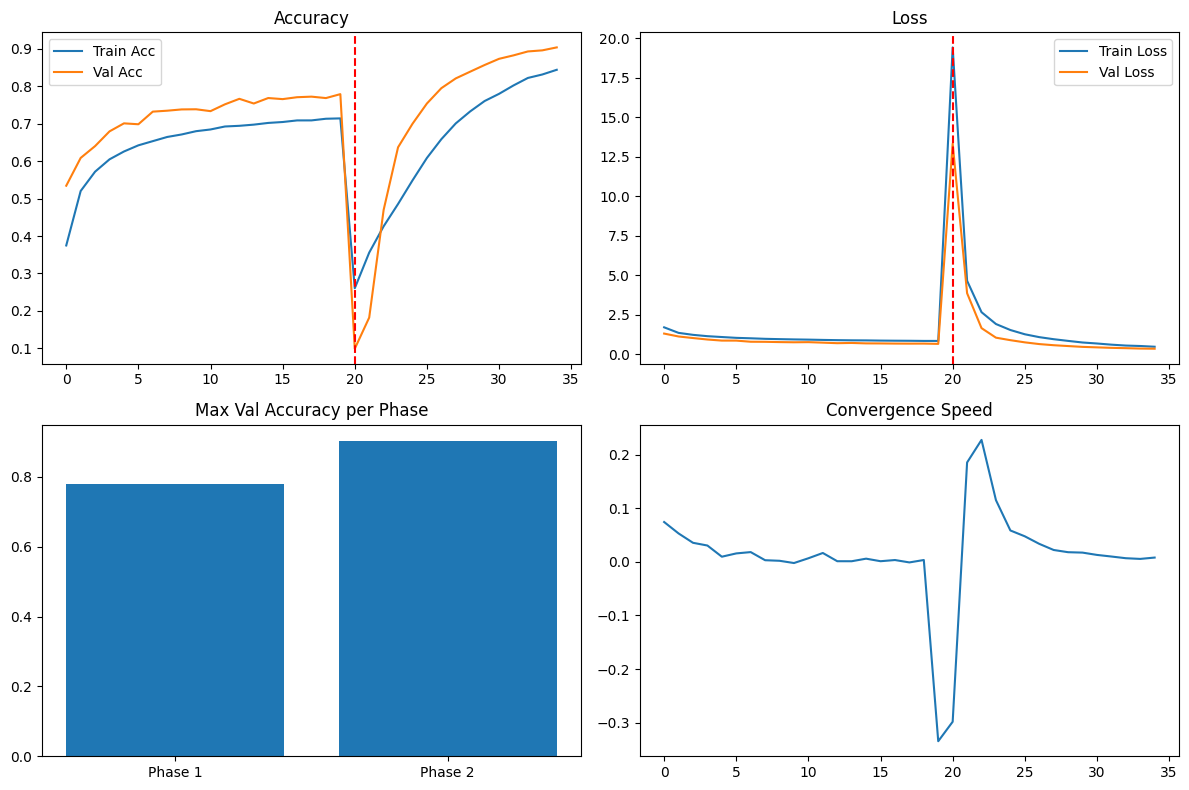

In [11]:
# Plot training history
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Acc')
plt.plot(combined_history['val_accuracy'], label='Val Acc')
plt.axvline(x=len(history1.history['accuracy']), color='red', linestyle='--')
plt.title('Accuracy')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Val Loss')
plt.axvline(x=len(history1.history['loss']), color='red', linestyle='--')
plt.title('Loss')
plt.legend()
plt.subplot(2, 2, 3)
max_acc1 = max(history1.history['val_accuracy'])
max_acc2 = max(history2.history['val_accuracy'])
plt.bar(['Phase 1', 'Phase 2'], [max_acc1, max_acc2])
plt.title('Max Val Accuracy per Phase')
plt.subplot(2, 2, 4)
plt.plot(np.gradient(combined_history['val_accuracy']))
plt.title('Convergence Speed')
plt.tight_layout()
plt.show()

Test Accuracy: 0.9036
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       980
           1       0.99      0.98      0.99      1135
           2       0.86      0.86      0.86      1032
           3       0.88      0.89      0.88      1010
           4       0.83      0.93      0.88       982
           5       0.83      0.89      0.86       892
           6       0.91      0.94      0.93       958
           7       0.95      0.90      0.92      1028
           8       0.95      0.82      0.88       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



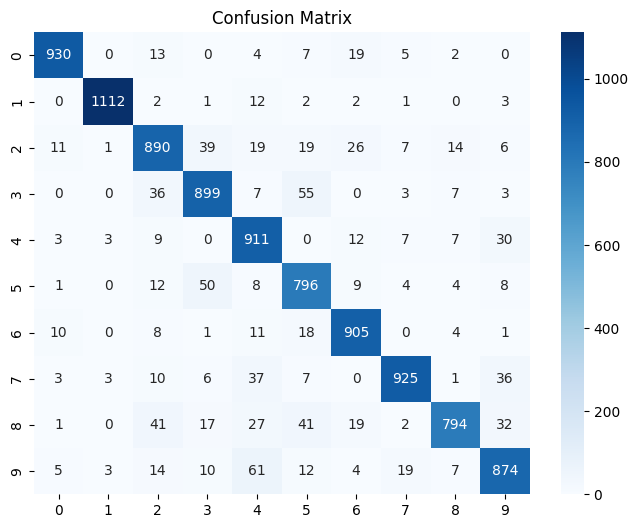

In [12]:
# Evaluate
test_loss, test_accuracy = model.evaluate(x_test_processed, y_test_processed, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
y_pred = model.predict(x_test_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_processed, axis=1)
print(classification_report(y_true_classes, y_pred_classes))
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Compare with previous CNN model
try:
    cnn_model = keras.models.load_model('mnist_cnn_model.h5')
    x_test_cnn = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(x_test_cnn, y_test, verbose=0)
    print(f"CNN Model Accuracy: {cnn_test_accuracy:.4f}")
    print(f"Transfer Learning Accuracy: {test_accuracy:.4f}")

    plt.figure(figsize=(6, 4))
    plt.bar(['CNN', 'Transfer Learning'], [cnn_test_accuracy, test_accuracy])
    plt.title('Model Comparison')
    plt.ylabel('Accuracy')
    plt.show()
except:
    print("CNN model not found")

CNN model not found


In [14]:
# Save model and history
model.save('saved_models/final_transfer_learning_model.h5')
with open('saved_models/training_history.pkl', 'wb') as f:
    pickle.dump(combined_history, f)
print("Model and history saved!")

Model and history saved!
